In [1]:
import pandas as pd

summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv',
                      encoding='iso-8859-1')
raw = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv',
                  encoding='iso-8859-1')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/news-summary/news_summary.csv'

In [2]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2

In [3]:
# read image
img = cv2.imread("C:\\Users\\Jay Ajmera\\Downloads\\Quest 4.jpg")

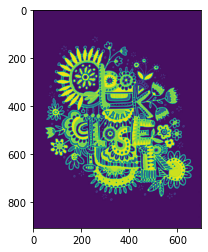

In [8]:
# Split r g and b
b, g, r = cv2.split(img)
#Plot r
plt.imshow()

In [7]:
# get model .h5
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
model = load_model('./aoml3.h5',custom_objects={'AttentionLayer': hub.KerasLayer()})

import pickle
#dump model
pickle.dump(model, open('model.pkl', 'wb'))

TypeError: __init__() missing 1 required positional argument: 'handle'

     ---------------------------------------- 0.0/46.1 kB ? eta -:--:--
     ---------------------------------------- 46.1/46.1 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -------- ------------------------------- 0.4/1.7 MB 11.2 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/1.7 MB 9.8 MB/s eta 0:00:01
   ---------------------- ----------------- 1.0/1.7 MB 7.7 MB/s eta 0:00:01
   -------------------------------------- - 1.7/1.7 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 9.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/376.9 MB ? eta -:--:--
   ---------------------------------------- 0.7/376.9 MB 23.8 MB/s eta 0:00:16
   ---------------------------------------- 1.4/376.9 MB 17.2 MB/s eta 0:00:22
   ---------------------------------------- 1.9/376.9 MB 15.4 MB/s eta 0:00:25
   ---------------------------------------- 2.5/376.9 MB 16.0 MB/s eta 0:00:24
   --------

  You can safely remove it manually.
  You can safely remove it manually.


In [2]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle




# Load your tokenizer from pickle file
with open('tokenizer.pickle', 'rb') as handle:
    y_tokenizer = pickle.load(handle)

# Extract dictionaries
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# Define maximum text length and maximum summary length
max_text_len = 575  # Adjust according to your model
max_summary_len = 75  # Adjust according to your model
latent_dim = 512  # Adjust according to your model

# Define the AttentionLayer class
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        assert isinstance(inputs, list)
        encoder_out_seq, decoder_out_seq = inputs

        # Attention mechanism
        score = tf.matmul(decoder_out_seq, encoder_out_seq, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=-1)
        context_vector = tf.matmul(attention_weights, encoder_out_seq)

        return context_vector, attention_weights

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape1 = input_shape[1][:2] + (input_shape[0][1],)
        shape2 = input_shape[1][:2] + (input_shape[0][0],)
        return [shape1, shape2]



# Load your LSTM model
model = load_model('aoml3.h5', custom_objects={'AttentionLayer': AttentionLayer})

# Load the encoder inputs and decoder inputs layers
encoder_inputs = model.input[0]
decoder_inputs = model.input[1]


encoder_model = Model(encoder_inputs, model.layers[2].output)

# Get the encoder outputs and states
encoder_outputs, state_h_enc, state_c_enc = encoder_model(encoder_inputs)
encoder_states = [state_h_enc, state_c_enc]


# Define the decoder layers
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

dec_emb_layer = model.layers[3]
dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_lstm = model.layers[4]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_layer = model.layers[5]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_dense = model.layers[6]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Define the decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# Function to preprocess input data
def preprocess_input(text):
    # Implement your tokenization logic here
    # Dummy tokenization: split text into words and map each word to an integer index
    tokenized_text = text.split()
    # Convert words to integer sequences
    input_sequence = [target_word_index[word] for word in tokenized_text if word in target_word_index]
    # Pad sequences to fixed length
    padded_sequence = pad_sequences([input_sequence], maxlen=max_text_len, padding='post')
    return padded_sequence

# Function to convert integer sequence to text
def seq2text(input_seq, reverse_dict):
    new_string = ''
    for index in input_seq[0]:
        word = reverse_dict.get(index, '')
        if word:
            new_string += word + ' '
    return new_string.strip()

# Function to generate summaries
def generate_summary(input_text):
    # Preprocess the input text
    preprocessed_text = preprocess_input(input_text)
    
    # Encode the input sequence to get the feature vector
    e_out = encoder_model.predict(preprocessed_text)
    e_h, e_c = e_out
    
    # Generate the summary using the decoder model
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence



txt = "The Indian cricket team won the match against New Zealand by 5 wickets. The match was held at the Oval stadium in London. The Indian team chased down the target of 250 runs in 48 overs. The top scorer for India was Rohit Sharma with 80 runs. The Indian team played well in all departments of the game. The bowlers took early wickets and restricted the New Zealand team to a low score. The batsmen chased down the target comfortably and secured a win for India. The Indian team will now play the final match against Australia to win the championship."
generate_summary(txt)

TypeError: Cannot iterate over a Tensor with unknown first dimension.

In [4]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Concatenate
import pickle

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle


# Custom AttentionLayer definition
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        assert isinstance(inputs, list)
        encoder_out_seq, decoder_out_seq = inputs

        # Attention mechanism
        score = tf.matmul(decoder_out_seq, encoder_out_seq, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=-1)
        context_vector = tf.matmul(attention_weights, encoder_out_seq)

        return context_vector, attention_weights

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape1 = input_shape[1][:2] + (input_shape[0][1],)
        shape2 = input_shape[1][:2] + (input_shape[0][0],)
        return [shape1, shape2]

# Load tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    y_tokenizer = pickle.load(handle)

reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# Load pre-trained models
custom_objects = {'AttentionLayer': AttentionLayer}
model = load_model('aoml3.h5', custom_objects=custom_objects)
encoder_model = load_model('encoder.h5', custom_objects=custom_objects)
decoder_model = load_model('decoder.h5', custom_objects=custom_objects)

# Model configuration - adjust as per your model
max_text_len = 575
max_summary_len = 75
latent_dim = 512  # Assuming this was your latent dimension

# Function for preprocessing input text
def preprocess_input(text):
    sequence = y_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_text_len, padding='post')
    return padded

# Function for decoding the sequence to text
def decode_sequence(input_seq):
    # Encode the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Start sequence with start token
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']

    decoded_sentence = ''
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_summary_len-1:
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        e_h, e_c = h, c

    return decoded_sentence.strip()

content = "The Indian cricket team won the match against New Zealand by 5 wickets. The match was held at the Oval stadium in London. The Indian team chased down the target of 250 runs in 48 overs. The top scorer for India was Rohit Sharma with 80 runs. The Indian team played well in all departments of the game. The bowlers took early wickets and restricted the New Zealand team to a low score. The batsmen chased down the target comfortably and secured a win for India. The Indian team will now play the final match against Australia to win the championship."
preprocessed_input = preprocess_input(content)
summary = decode_sequence(preprocessed_input)

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 575], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [10]:
pip show tensorflow

Name: tensorflowNote: you may need to restart the kernel to use updated packages.
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\jay ajmera\anaconda3\lib\site-packages
Requires: tensorflow-intel
Required-by: 



In [11]:
!pip install tensorflow==2.15.0

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Jay Ajmera\\anaconda3\\Lib\\site-packages\\~ensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-intel
    Found existing installation: tensorflow-intel 2.13.0
    Uninstalling tensorflow-intel-2.13.0:
      Successfully uninstalled tensorflow-intel-2.13.0
